In [ ]:
#
# Copyright 2018-2019 IBM Corp. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Object Detection - Visualize Results

This example illustrates the usage of [MAX Object Detector](https://developer.ibm.com/exchanges/models/all/max-object-detector) model. This notebook guides you through running the model on a sample image to get the objects, extracting the bounding boxes and then visualizing them over the image.


## Setup

The notebook calls the `MAX Object Detector` microservice, which must be running. You can either use the [hosted demo instance](http://max-object-detector.max.us-south.containers.appdomain.cloud), or follow the instructions for [deploying the microservice locally from the Dockerhub image](https://github.com/IBM/MAX-Object-Detector#deploy-from-docker-hub). 

In [ ]:
# This notebook requires matplotlib, Pillow and requests
# You only need to run the line below to install these if you don't already have them installed

# ! pip install -q matplotlib Pillow requests

In [1]:
import io
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import requests
import tensorflow as tf
import numpy as np
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
import re
import base64
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# Convert TensorFlow model file "model.tar.gz" from the older Protocol Buffer format to the
# newer SavedModel format.

!rm -rf saved_model
with open("./frozen_inference_graph.pb", "rb") as f:
    graph_def = tf.GraphDef.FromString(f.read())
g = tf.Graph();
with g.as_default():
    tf.graph_util.import_graph_def(graph_def, name="")
    
    with tf.Session() as sess:
        tf.saved_model.simple_save(sess, "saved_model", 
            inputs={"image":g.get_tensor_by_name("image_tensor:0")},
            outputs={"num_detections":g.get_tensor_by_name("num_detections:0"),
                     "detection_classes":g.get_tensor_by_name("detection_classes:0"),
                     "detection_boxes":g.get_tensor_by_name("detection_boxes:0"),
                     "detection_scores":g.get_tensor_by_name("detection_scores:0")})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.


2019-12-05 14:23:19,196 - tensorflow - WARNING - From <ipython-input-2-dbf2b3ac43b5>:17: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


2019-12-05 14:23:19,198 - tensorflow - WARNING - From /usr/local/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Assets added to graph.


2019-12-05 14:23:19,202 - tensorflow - INFO - Assets added to graph.


INFO:tensorflow:No assets to write.


2019-12-05 14:23:19,203 - tensorflow - INFO - No assets to write.


INFO:tensorflow:SavedModel written to: saved_model/saved_model.pb


2019-12-05 14:23:20,355 - tensorflow - INFO - SavedModel written to: saved_model/saved_model.pb


In [3]:
!cd saved_model/ && tar cvzf saved_model.tgz saved_model.pb
#!tar -cvzf saved_model.tar.gz saved_model

a saved_model.pb


In [4]:
import json
with open("./model_metadata.json") as f:
    model_metadata = json.load(f)
model_metadata

{'authorName': 'Dartagnan',
 'name': 'MAX Object Detector',
 'description': 'Deploy on IBM Cloud ML Service Instance',
 'frameworkName': 'tensorflow',
 'frameworkVersion': '1.13',
 'runtime_name': 'python',
 'runtime_version': '3.6'}

In [5]:
with open("./wml_credentials.json") as f:
    credentials = json.load(f)
credentials

{'apikey': '-Y-wte6OQgsy0ulPJ21Ik8BjAf3SK9o2utShJEXuIH99',
 'iam_apikey_description': 'Auto-generated for key 70cb3405-2b75-4b64-ba74-98f9eea170e7',
 'iam_apikey_name': 'WriterCredentials',
 'iam_role_crn': 'crn:v1:bluemix:public:iam::::serviceRole:Writer',
 'iam_serviceid_crn': 'crn:v1:bluemix:public:iam-identity::a/03f2e05d4bc74bf7a0948125d6c2bb7a::serviceid:ServiceId-25163d85-987b-4b81-9e4a-a5b3ac35d883',
 'instance_id': 'd4ebfd24-f9b3-457c-8002-f9e43c9024fd',
 'url': 'https://us-south.ml.cloud.ibm.com'}

In [6]:
client = WatsonMachineLearningAPIClient(credentials)

model_details = client.repository.store_model(
    model = "saved_model/saved_model.tgz",
    meta_props = model_metadata
)

In [7]:
all_models = client.repository.list()

------------------------------------  --------------------------------------  ------------------------  ---------------  -----------------
GUID                                  NAME                                    CREATED                   FRAMEWORK        TYPE
a05a8e41-1b12-4038-a5c8-94fac1a891af  Spark German Risk Model                 2019-12-05T00:14:59.008Z  mllib            definition
eb095ac7-afa9-4566-8e3d-4d01c5f08143  training def for credit-risk            2019-12-04T21:51:05.952Z  mllib            definition
fd33d8fd-cd70-45c7-825d-01f9273d1a14  training def for Credit Analysis Model  2019-12-04T21:26:11.558Z  mllib            definition
acabb77c-a40f-446d-bace-1395c9f1a951  MAX Object Detector                     2019-12-05T22:25:14.046Z  tensorflow-1.13  model
83684496-c22f-4d13-a6d3-b4065733767a  Spark German Risk Model                 2019-12-05T00:15:10.735Z  mllib-2.3        model
478ae749-bacd-4545-8c96-c42cda125dec  GermanCreditRiskModel                   2019-12

In [44]:
all_models

In [21]:
client.repository.delete("")

'SUCCESS'

In [8]:
deployment_details = client.deployments.create(model_details["metadata"]["guid"],
                                              name="MAX Object Detector")



#######################################################################################

Synchronous deployment creation for uid: 'acabb77c-a40f-446d-bace-1395c9f1a951' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='16f3fd23-a933-49ed-a49b-09c747abf599'
------------------------------------------------------------------------------------------------




In [9]:
all_deployments = client.deployments.get_uids()
all_deployments

['16f3fd23-a933-49ed-a49b-09c747abf599',
 '33df0cef-af46-48e3-b31e-3dd3b9ea5600',
 '76d320cc-e2f0-4370-abc2-8e3d3edf874c',
 'c6c02bcf-d300-4998-8c27-501fa3fc1cd6']

In [15]:
deployment_details

{'metadata': {'guid': '16f3fd23-a933-49ed-a49b-09c747abf599',
  'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/d4ebfd24-f9b3-457c-8002-f9e43c9024fd/deployments/16f3fd23-a933-49ed-a49b-09c747abf599',
  'created_at': '2019-12-05T22:31:03.217Z',
  'modified_at': '2019-12-05T22:31:03.479Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'name': 'Artifact deployment',
  'scoring_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/d4ebfd24-f9b3-457c-8002-f9e43c9024fd/deployments/16f3fd23-a933-49ed-a49b-09c747abf599/online',
  'deployable_asset': {'name': 'MAX Object Detector',
   'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/d4ebfd24-f9b3-457c-8002-f9e43c9024fd/published_models/acabb77c-a40f-446d-bace-1395c9f1a951',
   'guid': 'acabb77c-a40f-446d-bace-1395c9f1a951',
   'description': 'Deploy on IBM Cloud ML Service Instance',
   'created_at': '2019-12-05T22:31:03.192Z',
   'type': 'model'},
  'description': 'Description of deployment',
  'status_details': 

In [11]:
deployment_url = deployment_details["entity"]["deployed_version"]["url"]
deployment_url

'https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/acabb77c-a40f-446d-bace-1395c9f1a951/versions/b87367d0-1ff8-46af-b060-2a9aeecda9ea'

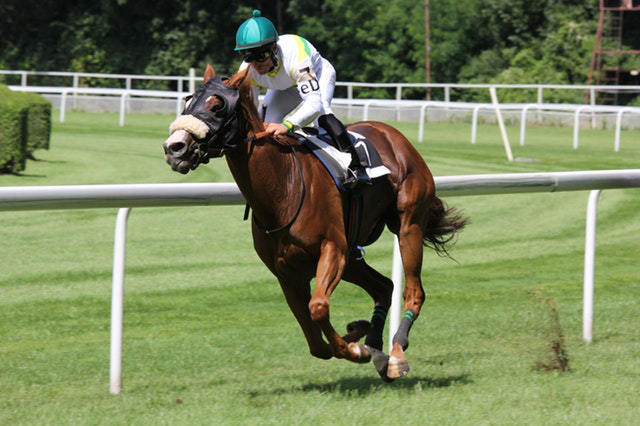

In [20]:
img_path = 'samples/jockey.jpg'
image = Image.open(img_path)
image

In [21]:
from utils import label_map_util
from config import NUM_CLASSES

label_map = label_map_util.load_labelmap('label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Score threshold
threshold = 0.5
# Map category IDs to category names
scoring_url = deployment_details["entity"]["scoring_url"]

# Preprocess converting raw pixels to features array
(im_width, im_height) = image.size
#image_array = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
image_array = np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)
scoring_payload = { "keyed_values":[ {"key":"image", "values":image_array.tolist() } ] }

# Evaluate the graph
json_result = client.deployments.score(scoring_url, scoring_payload)

# Postprocessing: Reformatting predictions into a more usable format
result = { v["key"]:v["values"][0] for v in json_result["keyed_values"] }

result_tuples = (
    {"score":t[0], "class_id":category_index[t[1]]['name'], "bounding_box":t[2]}
    for t in zip(result["detection_scores"], result["detection_classes"],
                 result["detection_boxes"])
)
filtered_result_tuples = [ r for r in result_tuples if r["score"] > threshold ]
filtered_result_tuples

[{'score': 0.9800630211830139,
  'class_id': 'horse',
  'bounding_box': [0.15102770924568176,
   0.25595152378082275,
   0.9119447469711304,
   0.7204357981681824]},
 {'score': 0.8138303756713867,
  'class_id': 'person',
  'bounding_box': [0.039235919713974,
   0.3334605097770691,
   0.4493279755115509,
   0.5806631445884705]}]

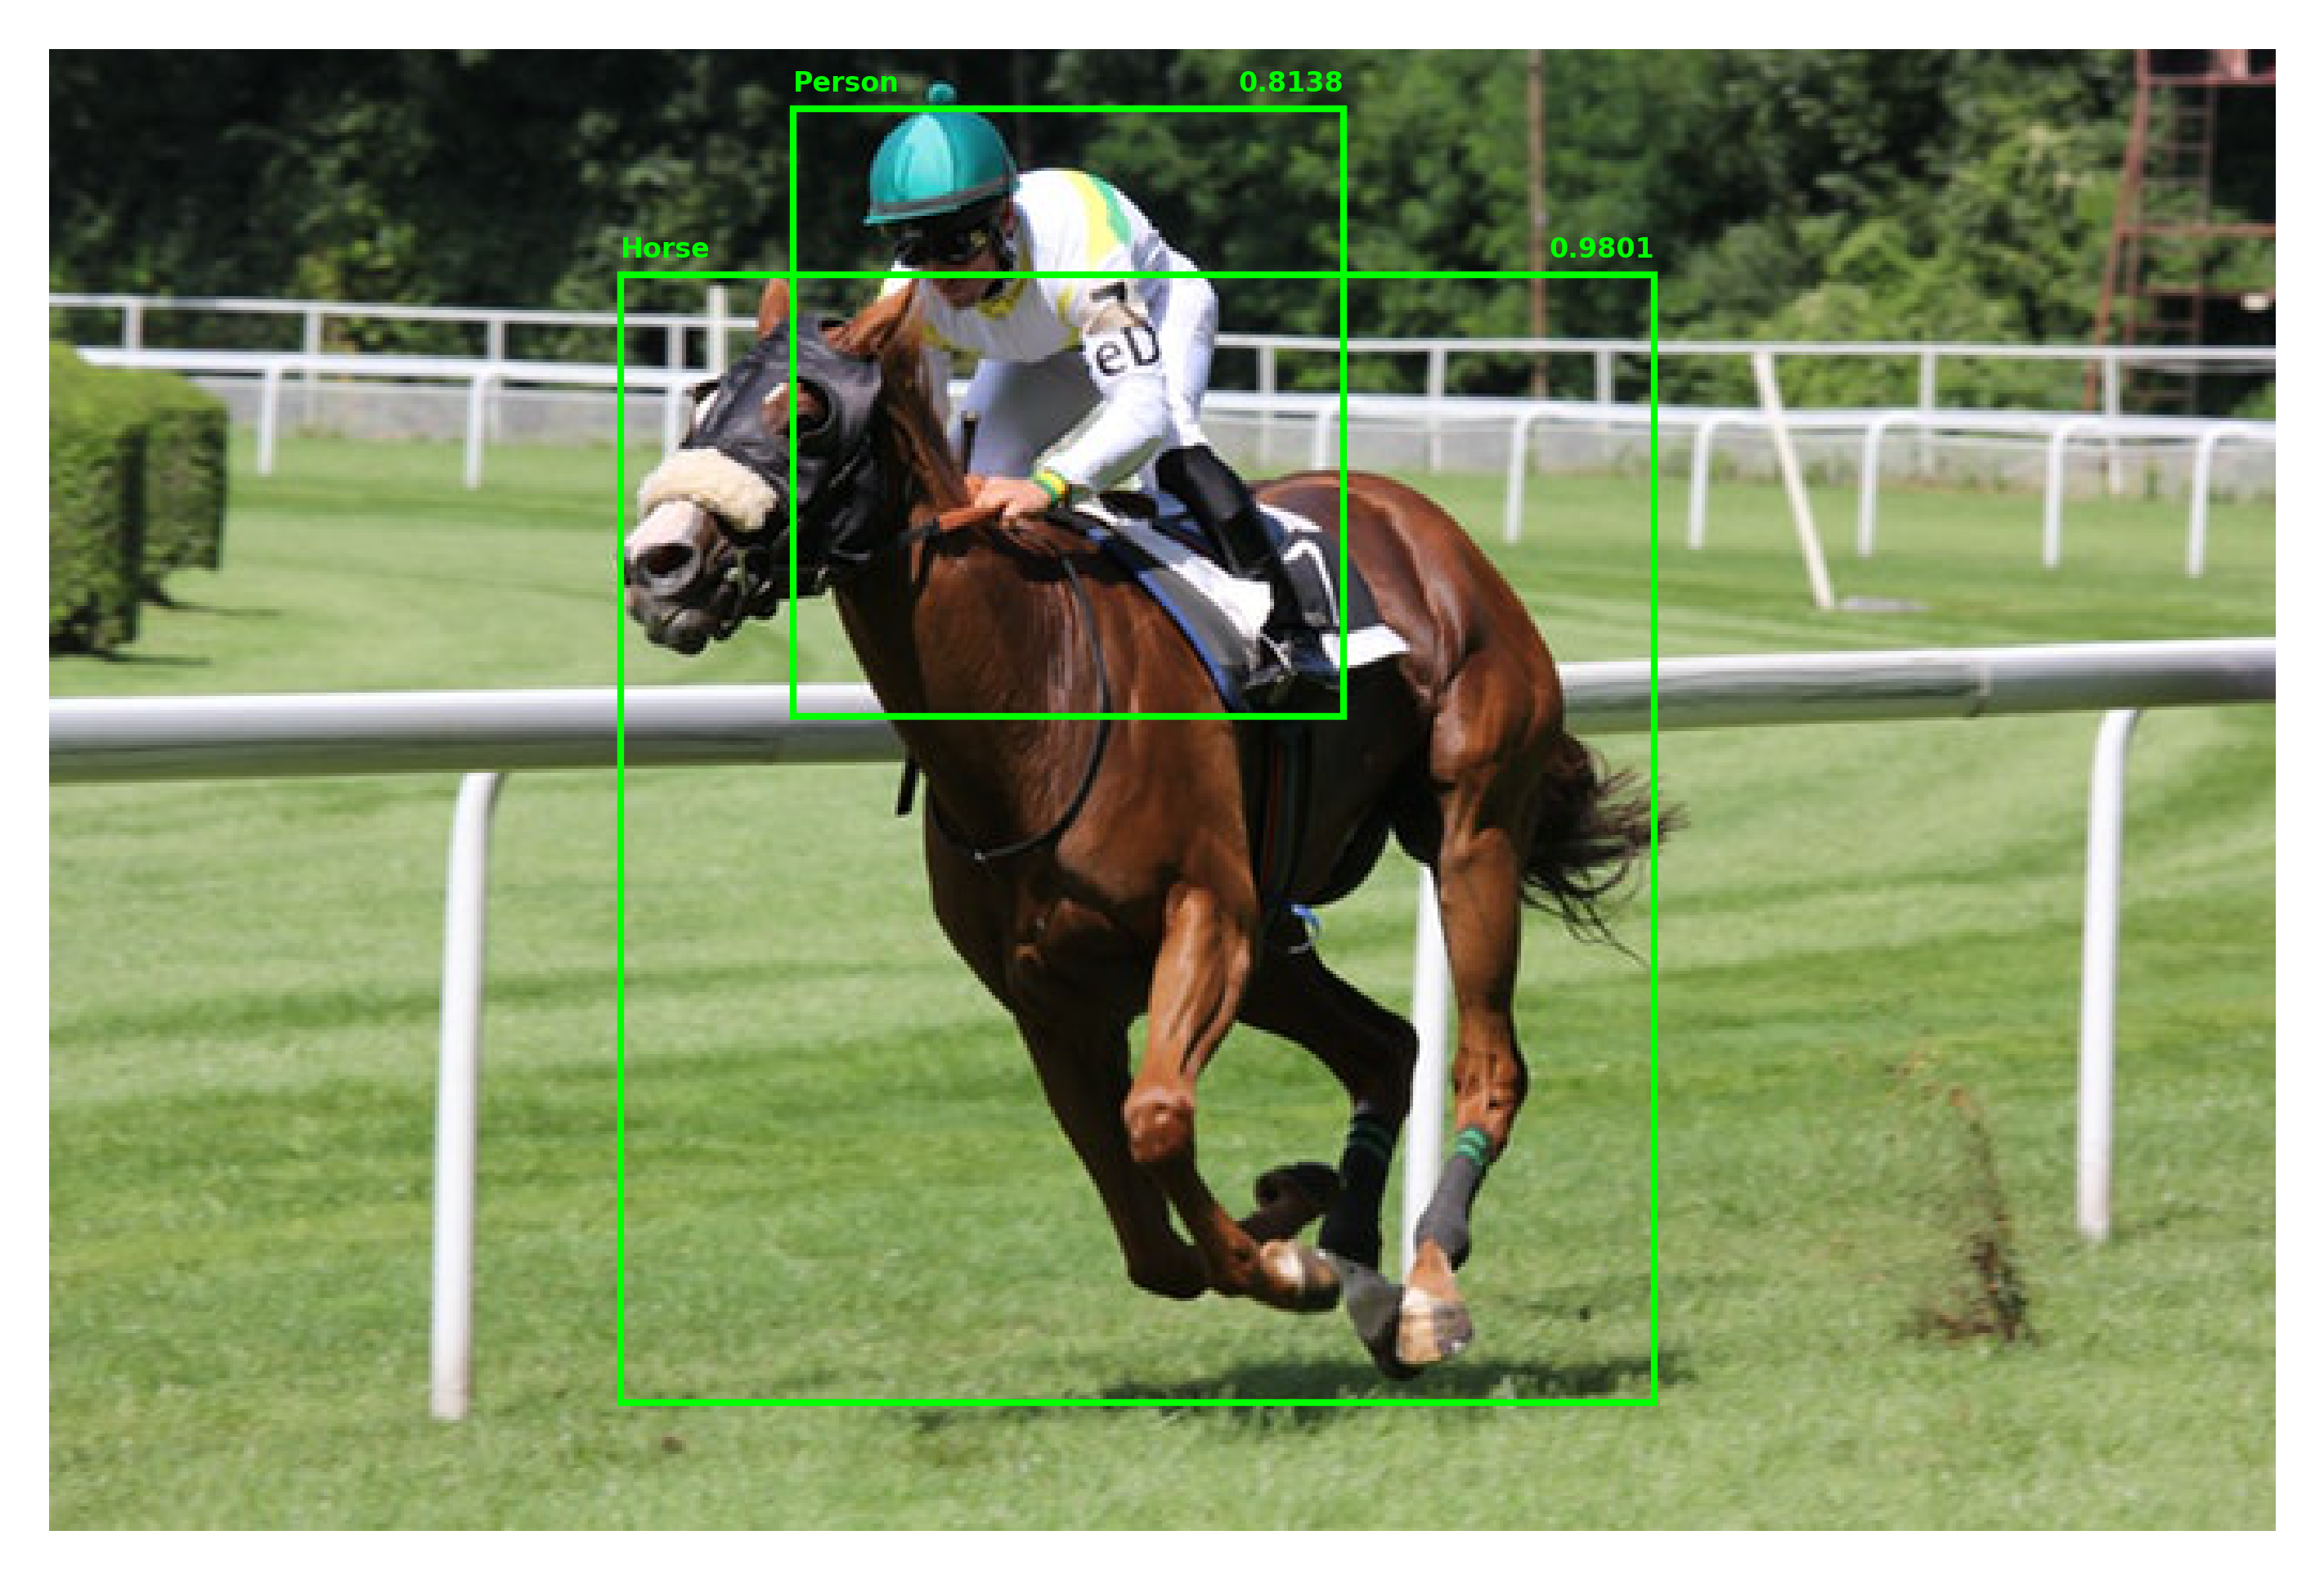

In [22]:
# We display bounding boxes and the class label with the predicted probability for each object.

# Get the image height and width
image_width, image_height = image.size
# Create figure and axes
fig, ax = plt.subplots()
# Set larger figure size
fig.set_dpi(600)
# Display the image
plt.imshow(image)

# Set up the color of the bounding boxes and text
color = '#00FF00'
# For each object, draw the bounding box and predicted class together with the probability
for prediction in filtered_result_tuples:
    bbox = prediction['bounding_box']
    # Unpack the coordinate values
    y1, x1, y2, x2 = bbox
    # Map the normalized coordinates to pixel values: scale by image height for 'y' and image width for 'x'
    y1 *= image_height
    y2 *= image_height
    x1 *= image_width
    x2 *= image_width
    # Format the class probability for display
    probability = '{0:.4f}'.format(prediction['score'])
    # Format the class label for display
    label = '{}'.format(prediction['class_id'])
    label = label.capitalize()
    # Create the bounding box rectangle - we need the base point (x, y) and the width and height of the rectangle
    rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rectangle)
    # Plot the bounding boxes and class labels with confidence scores
    plt.text(x1, y1-5, label, fontsize=4, color=color, fontweight='bold',horizontalalignment='left')
    plt.text(x2, y1-5, probability, fontsize=4, color=color, fontweight='bold',horizontalalignment='right')
plt.axis('off')
plt.show()